#                                      Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN

### Пути к директориям и файлам

In [175]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [176]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [177]:
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00000,NaN,0.00000,11.00000,26.30000,685960.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,99999999.00000,47386.00000,7914.00000,749.00000,0
1,Own Home,1025487.00000,10+ years,0.00000,15.00000,15.30000,1181730.00000,0.00000,NaN,0.00000,debt consolidation,Long Term,264968.00000,394972.00000,18373.00000,737.00000,1
2,Home Mortgage,751412.00000,8 years,0.00000,11.00000,35.00000,1182434.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,99999999.00000,308389.00000,13651.00000,742.00000,0
3,Own Home,805068.00000,6 years,0.00000,8.00000,22.50000,147400.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,121396.00000,95855.00000,11338.00000,694.00000,0
4,Rent,776264.00000,8 years,0.00000,13.00000,13.60000,385836.00000,1.00000,NaN,0.00000,debt consolidation,Short Term,125840.00000,93309.00000,7180.00000,719.00000,0


In [178]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [179]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [180]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00000,7500.00000,7500.00000,7500.00000,7500.00000,7500.00000,3419.00000,7486.00000,7500.00000,7500.00000,7500.00000,5943.00000,7500.00000
mean,1366391.72017,0.03013,11.13093,18.31747,945153.72747,0.17000,34.69260,0.11715,11873177.44507,289833.23520,18314.45413,1151.08750,0.28173
std,845339.19963,0.27160,4.90892,7.04195,16026216.67085,0.49860,21.68881,0.34719,31926122.97473,317871.38238,11926.76467,1604.45142,0.44987
min,164597.00000,0.00000,2.00000,4.00000,0.00000,0.00000,0.00000,0.00000,11242.00000,0.00000,0.00000,585.00000,0.00000
25%,844341.00000,0.00000,8.00000,13.50000,279229.50000,0.00000,16.00000,0.00000,180169.00000,114256.50000,10067.50000,711.00000,0.00000
50%,1168386.00000,0.00000,10.00000,17.00000,478159.00000,0.00000,32.00000,0.00000,309573.00000,209323.00000,16076.50000,731.00000,0.00000
75%,1640137.00000,0.00000,14.00000,21.80000,793501.50000,0.00000,50.00000,0.00000,519882.00000,360406.25000,23818.00000,743.00000,1.00000
max,10149344.00000,7.00000,43.00000,57.70000,1304726170.00000,7.00000,118.00000,4.00000,99999999.00000,6506797.00000,136679.00000,7510.00000,1.00000


- Maximum Open Credit обработать выбросы
- Current Loan Amount обработать выбросы
- Current Credit Balance - посмотреть выброс или нет.
- Credit score -  посмотреть частоту значений, возможно верхняя граница это просто ошибка лишей цифры.
- Current Credit Balance, Monthly Debt - посмотреть 0 значения.

### Выбросы

#### Maximum Open Credit

<AxesSubplot:xlabel='Maximum Open Credit'>

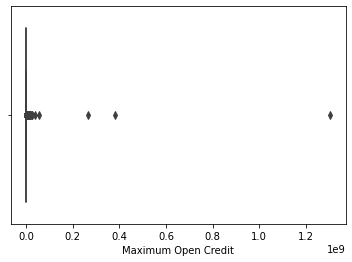

In [181]:
sns.boxplot(df_train['Maximum Open Credit'])

Значения совсем фантастические. Заменим все что выше q=0.975 медианой.

In [182]:
max_open_credit = np.quantile(df_train['Maximum Open Credit'], q=0.975)
max_open_credit_median = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median

#### Current Loan Amount

In [183]:
df_train['Current Loan Amount'].value_counts()

99999999.00000    870
218064.00000        6
89298.00000         6
216106.00000        5
265826.00000        5
                 ... 
104324.00000        1
201080.00000        1
427812.00000        1
665544.00000        1
191136.00000        1
Name: Current Loan Amount, Length: 5386, dtype: int64

<AxesSubplot:>

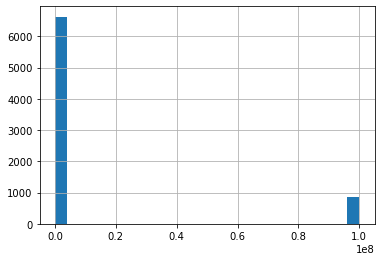

In [184]:
df_train['Current Loan Amount'].hist(bins=25)

Я так подозреваю значение 99999999 это правое скопление, явно не являющееся нормальным. Заменим медианным значением, и создадим доп признак показывающий, что был выброс, т.к. выбросов очень много.

In [185]:
current_loan_amount_median = df_train['Current Loan Amount'].median()

df_train["Current Loan Amount outlier"] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = current_loan_amount_median

#### Current Credit Balance

Верхняя граница достаточно большая, но и не чтоб супербольшая. Хотя не известно, включается ли тут деньги лежащие на дебетовом счете в общую сумму. Можно посмотреть, например сколько счетов у людей, у которых кредитный счет больше 0.975 квантиля, или же можем посмотреть людей у которых кредитный счет выше чем сумма кредита. 

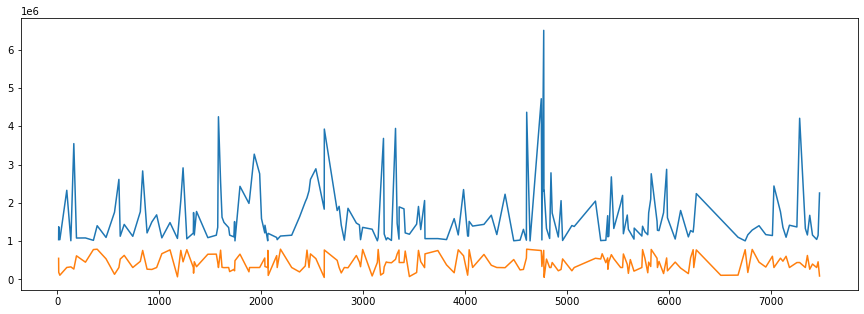

In [186]:
high_credit_balance = df_train.loc[df_train['Current Credit Balance'] > np.quantile(df_train['Current Credit Balance'], q=0.975)]
x = high_credit_balance['Current Credit Balance']
y = high_credit_balance['Current Loan Amount']

plt.figure(figsize=(15,5))

plt.plot(x)
plt.plot(y)

Интересно, я думаю дальше можно создать признак, помечающий людей, у которых баланс больше кредита. 

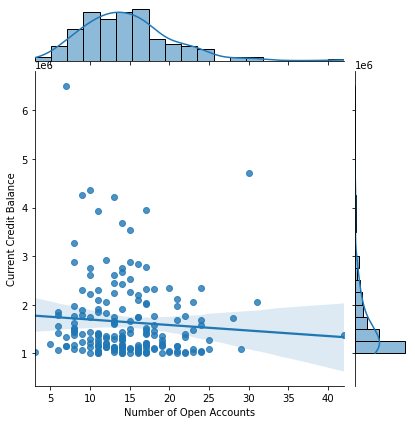

In [187]:
z =  high_credit_balance['Number of Open Accounts']

sns.jointplot(z,x, kind='reg')

Связь с количеством счетов почти никакая. Остановимся на том, что пометим у кого баланс больше кредита.

#### Monthly Debt

Теперь нужно посмотреть нули.

In [188]:
df_train.loc[df_train['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount outlier
780,Home Mortgage,867749.00000,10+ years,0.00000,2.00000,16.50000,0.00000,0.00000,66.00000,0.00000,home improvements,Short Term,75350.00000,0.00000,0.00000,704.00000,0,0
1643,Rent,NaN,9 years,0.00000,3.00000,10.00000,0.00000,0.00000,NaN,0.00000,other,Short Term,332156.00000,0.00000,0.00000,NaN,1,0
3219,Home Mortgage,NaN,10+ years,0.00000,3.00000,18.50000,0.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,79200.00000,0.00000,0.00000,NaN,0,0
3496,Rent,233567.00000,1 year,0.00000,7.00000,11.70000,0.00000,0.00000,0.00000,NaN,educational expenses,Short Term,210166.00000,0.00000,0.00000,746.00000,0,0
4165,Rent,1254513.00000,10+ years,0.00000,6.00000,23.40000,0.00000,0.00000,60.00000,0.00000,take a trip,Short Term,309573.00000,0.00000,0.00000,748.00000,0,1
7124,Rent,NaN,1 year,0.00000,4.00000,11.00000,0.00000,0.00000,50.00000,0.00000,debt consolidation,Short Term,134024.00000,0.00000,0.00000,NaN,0,0


In [189]:
df_train['Monthly Debt'].median()

16076.5

Вообще ерунда, кредитная история много лет, максимальный кредит 0, при этом просрочка кредита у некторых имеется. В тоже время имеется взятый кредит, но выплата 0 в месяц. Мусорные наблюдения, которые стоит выкинуть.  Я посмотрел в тестовом дата сете, таких там нет, по этому тут просто выкинем. Если бы у нас был признак точного срока кредита, можно былобы расчитать, но мы имеем только (короткий\длинный).

In [190]:
df_train = df_train.loc[df_train['Monthly Debt'] != 0]

Вообще нижняя планка меня удивляет, куча наблюдений, в которых короткое время кредита, при этом ежемесячный платеж  0.1% - 0.5%  от суммы. С другой стороны, конечно, если мне, грубо говоря, надо отдавать 100руб в месяц за кредит, то вероятность, что я отдам очень высока.

В общем делаем так, те что ниже нижней границы и при этом срок выплаты более 10 лет, мы считаем выбросами и подгоняем под значение, когда мы бы выплачивали весь кредит в течении  17 месяцев. (это среднее время выплаты всех кредитов)

In [191]:
min_monthly_debt = np.quantile(df_train['Monthly Debt'], q=0.025)
mean_monthly_debt_months = df_train['Current Loan Amount'].mean() / df_train['Monthly Debt'].mean()

df_train.loc[(df_train['Monthly Debt'] < min_monthly_debt) & ((df_train['Current Loan Amount'] / df_train['Monthly Debt']) > 120), 'Monthly Debt'] = df_train['Current Loan Amount'] / mean_monthly_debt_months

#### Credit Score

<AxesSubplot:>

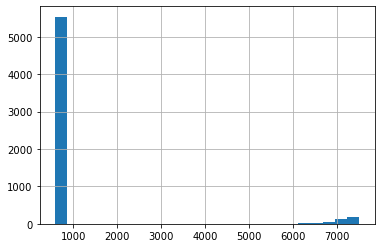

In [192]:
df_train["Credit Score"].hist(bins=25)

In [193]:
df_train["Credit Score"].value_counts()

740.00000     169
747.00000     168
748.00000     156
745.00000     152
742.00000     151
             ... 
629.00000       1
606.00000       1
6830.00000      1
6670.00000      1
620.00000       1
Name: Credit Score, Length: 268, dtype: int64

Да, сделаем обрезание крайней цифры. =)

In [194]:
df_train.loc[df_train['Credit Score'] > 2000, 'Credit Score'] //= 10

### Пропуски

#### Annual Income 

Подумаем, чем можно заполнить пропуски. Значений довольно много, просто какойто средней или медианой заполнять получится перекос. Либо делаем так и создаем признак, и отмечаем, что было пропущено значение, либо выбрать метод заполнения по хитрее. 

In [195]:
df_train["Annual Income"].mean()

1366685.2127946129

Можно посмотреть, как разделяется среднее по стажу работы.

In [196]:
df_train.groupby(by="Years in current job")["Annual Income"].mean()

Years in current job
1 year      1271418.78841
10+ years   1511082.12439
2 years     1324516.68157
3 years     1396487.28163
4 years     1371733.44865
5 years     1330785.57323
6 years     1311730.11966
7 years     1341805.04545
8 years     1390800.27143
9 years     1444429.35979
< 1 year    1204723.05369
Name: Annual Income, dtype: float64

Не особо сильно, но явно виден рост зп со стажем, что стоило ожидать.
В теории, ежемесячный платеж должен быть завязан на ЗП, можно посмотреть по матрице корреляции данный признак.

In [197]:
corr_matrix = df_train.corr()
corr_matrix["Annual Income"]

Annual Income                   1.00000
Tax Liens                       0.06622
Number of Open Accounts         0.18824
Years of Credit History         0.18637
Maximum Open Credit             0.29853
Number of Credit Problems      -0.01553
Months since last delinquent   -0.10232
Bankruptcies                   -0.06692
Current Loan Amount             0.41775
Current Credit Balance          0.38632
Monthly Debt                    0.58951
Credit Score                    0.02876
Credit Default                 -0.10161
Current Loan Amount outlier     0.03002
Name: Annual Income, dtype: float64

Я был прав, самая большая корреляция с Ежемесячным платежом. Можно например узнать соотношение средней ЗП по всем к средней Ежемесячных платежей, далее предсказывать пропущенные ЗП домножая на коэффициент. Ну и всеже стоит их пометить.

In [198]:
annual_incom_coef = df_train["Annual Income"].mean() / df_train['Monthly Debt'].mean()

In [199]:
df_train["Annual Income NAN"] = 0
df_train.loc[df_train["Annual Income"].isnull(), "Annual Income NAN"] = 1

In [200]:
df_train.loc[df_train["Annual Income"].isnull(), "Annual Income"] = df_train["Monthly Debt"] * annual_incom_coef

In [201]:
df_train.loc[df_train["Annual Income NAN"] == 1, "Annual Income"].describe()

count      1554.00000
mean    1375401.60450
std      882701.29697
min       55624.45356
25%      765795.27882
50%     1197806.95001
75%     1762756.63887
max     7095216.27388
Name: Annual Income, dtype: float64

Почти не отличается от средней по этому признаку, однако распределение значений более честное, на мой взгляд.

#### Years in current job

Ну тут значений не много, заменим модой

In [202]:
current_job_mode = df_train['Years in current job'].mode()[0]

In [203]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = current_job_mode

#### Months since last delinquent

Признак не простой, вероятнее всего пропущенные значения, это клиенты которые никогда не просрачивали кредит, и важно это правильно объяснить модели т.к. это весомый довод выдать кредит. Мы не можем написать 0, т.к. это значит, что просрока была в это м месяце. Нужно большое число. Можно года кредитной истории умножить на 12 и также создать доп признак.

In [204]:
df_train.loc[df_train['Months since last delinquent'].isnull()]['Credit Default'].value_counts()

0    2950
1    1129
Name: Credit Default, dtype: int64

Хотя даже такие ребята, которые не имели просрочки, имеют соотношение целевого признака 1к3. Но делать нечего, надо както заполнять.

<AxesSubplot:>

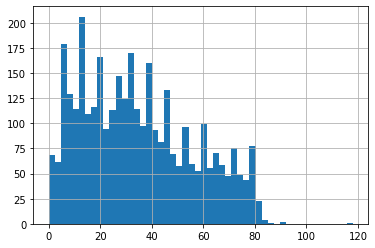

In [205]:
df_train['Months since last delinquent'].hist(bins=50)

In [206]:
df_train['Delinquent'] = 1
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Delinquent'] = 0
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Years of Credit History'] * 12

<AxesSubplot:>

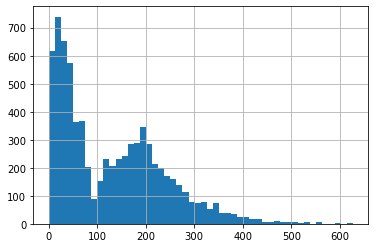

In [207]:
df_train['Months since last delinquent'].hist(bins=50)

Рисковая практика, получился целый доп кластер. Попробуем пока оставить. С одной стороны информация то полезная, когда был послений прокол.. И доп признак, Были просрочки \ Не было. 

Либо просто оставляем доп признак.

#### Bankruptcies

Тут пропусков не много, можно заменить медианой.

In [208]:
bankruptcies_median = df_train['Bankruptcies'].median()

In [209]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_median

#### Credit Score

In [210]:
corr_matrix = df_train.corr()
corr_matrix["Credit Score"]

Annual Income                   0.02876
Tax Liens                      -0.01646
Number of Open Accounts        -0.03465
Years of Credit History         0.06838
Maximum Open Credit             0.11219
Number of Credit Problems      -0.05502
Months since last delinquent    0.11225
Bankruptcies                   -0.04135
Current Loan Amount            -0.20503
Current Credit Balance         -0.00544
Monthly Debt                   -0.07009
Credit Score                    1.00000
Credit Default                 -0.20707
Current Loan Amount outlier     0.14991
Annual Income NAN                   NaN
Delinquent                     -0.09238
Name: Credit Score, dtype: float64

Для более точного предсказания хорошо бы знать формулу расчета рейтинга, т.к. корреляции слабые, для нормальних предсказаний, заполним медианой и пометим.

In [211]:
credit_score_median = df_train['Credit Score'].median()

In [212]:
df_train['Credit Score NAN'] = 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score NAN'] = 1
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = credit_score_median

In [213]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7494 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7494 non-null   object 
 1   Annual Income                 7494 non-null   float64
 2   Years in current job          7494 non-null   object 
 3   Tax Liens                     7494 non-null   float64
 4   Number of Open Accounts       7494 non-null   float64
 5   Years of Credit History       7494 non-null   float64
 6   Maximum Open Credit           7494 non-null   float64
 7   Number of Credit Problems     7494 non-null   float64
 8   Months since last delinquent  7494 non-null   float64
 9   Bankruptcies                  7494 non-null   float64
 10  Purpose                       7494 non-null   object 
 11  Term                          7494 non-null   object 
 12  Current Loan Amount           7494 non-null   float64
 13  Cur

### Обработка не числовых значений.

#### Home Ownership

In [214]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3635
Rent             3200
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [215]:
df_train.groupby(by='Home Ownership')['Credit Default'].mean()

Home Ownership
Have Mortgage   0.16667
Home Mortgage   0.25199
Own Home        0.29675
Rent            0.31312
Name: Credit Default, dtype: float64

Чем больше среднее, тем больше наблюдений 1 класса. Интересно, что у тех, кто арендует дома\квартиру, не погашен кредит чаще всего. Можно заменить тип домовладения, соответствующей статистикой.

In [216]:
home_ownership_credit_default_stat = df_train.groupby(by='Home Ownership')['Credit Default'].mean().to_dict()

In [217]:
df_train.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )

#### Years in current job

In [218]:
df_train['Years in current job'].value_counts()

10+ years    2700
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        502
4 years       469
6 years       426
7 years       396
8 years       339
9 years       258
Name: Years in current job, dtype: int64

Тут можно просто, перевести в непрерывный тип, т.к. по сути признак таким и является. 

In [219]:
years_in_current_job_dict = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}

In [220]:
df_train.replace({'Years in current job': years_in_current_job_dict}, inplace=True)

#### Purpose

In [221]:
df_train['Purpose'].value_counts()

debt consolidation      5942
other                    664
home improvements        411
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               36
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses       9
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Много значений. Надо прикинуть, как их можно описать другими признаками. Например цель кредита всегда влияет на размер кредита. Можно прикинуть средний размер кредита, который берут на эту цель и записать в значения.

In [222]:
purpose_stat = df_train.groupby(by='Purpose')['Current Loan Amount'].mean().to_dict()

In [223]:
df_train.replace({'Purpose': purpose_stat}, inplace=True)

####  Term

In [224]:
df_train['Term'].value_counts()

Short Term    5550
Long Term     1944
Name: Term, dtype: int64

Просто переведем в бинарный признак.

In [225]:
df_train['Term'] = (df_train['Term'] == 'Short Term').astype(int)

In [226]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7494 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7494 non-null   float64
 1   Annual Income                 7494 non-null   float64
 2   Years in current job          7494 non-null   int64  
 3   Tax Liens                     7494 non-null   float64
 4   Number of Open Accounts       7494 non-null   float64
 5   Years of Credit History       7494 non-null   float64
 6   Maximum Open Credit           7494 non-null   float64
 7   Number of Credit Problems     7494 non-null   float64
 8   Months since last delinquent  7494 non-null   float64
 9   Bankruptcies                  7494 non-null   float64
 10  Purpose                       7494 non-null   float64
 11  Term                          7494 non-null   int32  
 12  Current Loan Amount           7494 non-null   float64
 13  Cur

### Доп анализ \ Новые фичи

Как и писал выше, когда просматривал выбросы, создадим признак, отмечающий наблюдения, в которых сумма на счете превышает сумму кредита.

In [227]:
df_train["Big_balance"] = 0
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Loan Amount'], "Big_balance"] = 1

In [228]:
df_train["Big_balance"].value_counts()

0    4908
1    2586
Name: Big_balance, dtype: int64

***

Посмотрим признаки, к которым еще не обращались. 

In [229]:
df_train['Tax Liens'].value_counts()

0.00000    7360
1.00000      83
2.00000      30
3.00000      10
4.00000       6
6.00000       2
5.00000       2
7.00000       1
Name: Tax Liens, dtype: int64

С таким балансом признак практически не будет иметь вес.

***

<AxesSubplot:>

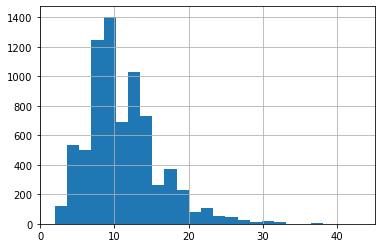

In [230]:
df_train['Number of Open Accounts'].hist(bins=25)

***

In [231]:
df_train['Number of Credit Problems'].value_counts()

0.00000    6463
1.00000     882
2.00000      93
3.00000      35
4.00000       9
5.00000       7
6.00000       4
7.00000       1
Name: Number of Credit Problems, dtype: int64

Что за проблемы с кредитом не понятно. Может быть отказы в других банках? В таком случае такой непрерывный вид оптималный...

Надо прикинуть, какие факторы из известных признаков могут спровоцировать не уплату кредита.
1) Самое вероятное, это малая ЗП.
Мы считали выше коэффициент соотноршения ЗП к 
2) Возможно состояние кредитного счета. К примеру если на счету денег меньше чем ежемесячный платеж.

In [245]:
annual_incom_coef

73.77248483400273

Посмотрим на граффиках по парного рассеяния, может какието доп зависимости удастся увидеть.

*Покачто отключу, т.к. много времени на постройку занимает.

На мой не опытный глаз никаких особых зависимостей не увидел.

In [234]:
scaler = RobustScaler()

In [235]:
scaled_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)  

In [236]:
scaled_x_train = scaled_train.drop(['Credit Default'],1)
scaled_y_train = scaled_train['Credit Default']


#### Переменные

#### Функция предобработки данных

In [241]:
def prep_data(df):
    
    #Выбросы
    
    df.loc[df['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median
    
    df["Current Loan Amount outlier"] = 0
    df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount outlier'] = 1
    df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = current_loan_amount_median
    
    df = df.loc[df['Monthly Debt'] != 0]
    df.loc[(df['Monthly Debt'] < min_monthly_debt) & ((df['Current Loan Amount'] / df['Monthly Debt']) > 120), 'Monthly Debt'] = df['Current Loan Amount'] / mean_monthly_debt_months
    
    df.loc[df['Credit Score'] > 2000, 'Credit Score'] //= 10
    
    #Пропуски
    
    df["Annual Income NAN"] = 0
    df.loc[df["Annual Income"].isnull(), "Annual Income NAN"] = 1
    df.loc[df["Annual Income"].isnull(), "Annual Income"] = df["Monthly Debt"] * annual_incom_coef
    
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = current_job_mode
    
    df['Months since last delinquent NAN'] = 1
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent NAN'] = 0
    df = df.drop('Months since last delinquent', 1)
    
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = bankruptcies_median
    
    df['Credit Score NAN'] = 0
    df.loc[df['Credit Score'].isnull(), 'Credit Score NAN'] = 1
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = credit_score_median
    
    #Фичи
    
    df.replace({"Home Ownership": home_ownership_credit_default_stat}, inplace=True )
    
    df.replace({'Years in current job': years_in_current_job_dict}, inplace=True)
    
    df.replace({'Purpose': purpose_stat}, inplace=True)
    
    df['Term'] = (df['Term'] == 'Short Term').astype(int)
    
    df["Big_balance"] = 0
    df.loc[df['Current Credit Balance'] > df['Current Loan Amount'], "Big_balance"] = 1
    return df